In [ ]:
#If you want to use colab use these lines of code
#Dataset,Model,XML Used : https://drive.google.com/drive/folders/1a23XTqGKBCtiTztt6JNzBybN9MWD9Slh?usp=share_link

from google.colab import drive
drive.mount('/content/drive')

from zipfile import ZipFile
with ZipFile ('drive/MyDrive/content/mask_dataset.zip', 'r') as zipObj:
  zipObj.extractall('drive/MyDrive/content/mask_dataset')

In [29]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
import glob as gb
import scipy
import random
import seaborn as sns
import os
from PIL import Image
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [2]:
resize = 224   #input image size
learning_rate = 1e-4
seed = 107
#define the hyperparamets for traing te neural network
INIT_LR = 1e-4
EPOCHS = 17
BS = 64
#dir_mask = 'drive/MyDrive/content/mask_dataset/with_mask'
#dir_inc_mask = 'drive/MyDrive/content/mask_dataset/mask_weared_incorrect'
#dir_nomask = 'drive/MyDrive/content/mask_dataset/without_mask'
#TRAIN_DIR = 'drive/MyDrive/content/mask_dataset'

dir_mask = 'Z:/Face-Mask/mask_dataset/with_mask'
dir_inc_mask = 'Z:/Face-Mask/mask_dataset/mask_weared_incorrect'
dir_nomask = 'Z:/Face-Mask/mask_dataset/without_mask'
TRAIN_DIR = 'Z:/Face-Mask/mask_dataset'

assert os.path.exists(dir_mask), 'Could not find' + dir_mask
assert os.path.exists(dir_inc_mask), 'Could not find' + dir_inc_mask
assert os.path.exists(dir_nomask), 'Could not find' + dir_nomask

100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


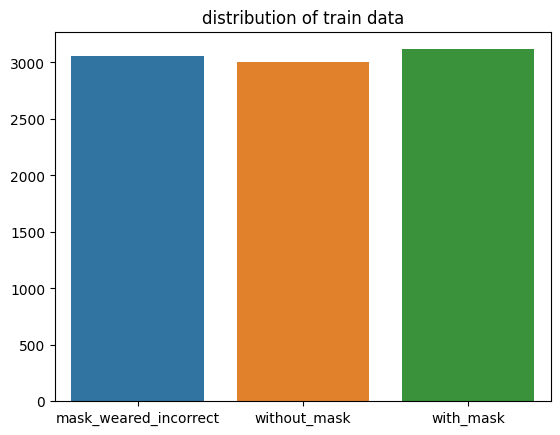

9181


100%|██████████| 3118/3118 [01:40<00:00, 31.02it/s]


In [3]:
categories = []
class_count = []
train_exm = 0

for f in tqdm(os.listdir(TRAIN_DIR)):
    files = gb.glob(pathname=str(TRAIN_DIR  + '//' + f + '/*'))
    categories.append(f)
    class_count.append(len(files))
    train_exm += len(files)

sns.barplot(x=categories, y=class_count).set_title("distribution of train data")
plt.show()
print(train_exm)

# Joining code starts here
#CATEGORIES = ["with_mask", "mask_weared_incorrect", "without_mask"]
data = []
labels = []

for c in categories:
    path = os.path.join(TRAIN_DIR, c)
    for img in tqdm(os.listdir(path)):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(resize, resize))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        data.append(image)
        labels.append(c)
        
data= np.array(data, dtype="float32")
labels = np.array(labels)

In [4]:
len(labels)

9181

In [5]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{'mask_weared_incorrect': 3058, 'with_mask': 3118, 'without_mask': 3005}

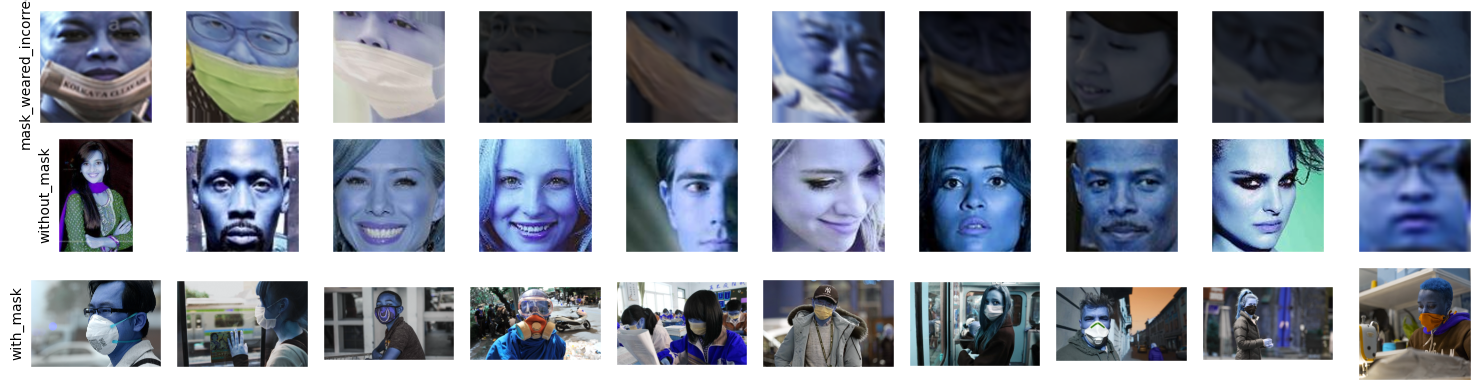

In [21]:
plt.figure(figsize=(15,4))
i=0
for c in categories:  
    path = os.path.join(TRAIN_DIR,c)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        plt.subplot(3,10,i+1)
        plt.imshow(img_array)
        if i%10 == 0:
            plt.ylabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        if i%10 == 0:
            break

plt.tight_layout()        
plt.show()


In [14]:
#Encode the labels in one hot encode form
lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [15]:
AugmentedData = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    )

In [16]:
#define the model
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_shape=(224, 224, 3))
baseModel.summary()

# construct the head of the model that will be placed on top of the
# the base model (A simple CNN as the Head model) 
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [17]:
#divide data into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.2, stratify=labels, random_state=42)

print(f"Shape of x_train: {trainX.shape}")
print(f"Shape of y_train: {trainY.shape}")
print()
print(f"Shape of x_test: {testX.shape}")
print(f"Shape of y_test: {testY.shape}")



Shape of x_train: (7344, 224, 224, 3)
Shape of y_train: (7344, 3)

Shape of x_test: (1837, 224, 224, 3)
Shape of y_test: (1837, 3)


In [18]:
#Complie the model and train it
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("""[INFO] compiling model...
[INFO] training head...""")


# train the head of the network
H = model.fit(
	AugmentedData.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    
	epochs=EPOCHS) #Here we sets weights to each class. 
#Class having high weight will be considered more importat while training

[INFO] compiling model...
[INFO] training head...
Epoch 1/17
114/114 [==============================] - 288s 2s/step - loss: 1.2189 - accuracy: 0.3316 - val_loss: 1.1328 - val_accuracy: 0.3413
Epoch 2/17
114/114 [==============================] - 260s 2s/step - loss: 1.1446 - accuracy: 0.3359 - val_loss: 1.1150 - val_accuracy: 0.3527
Epoch 3/17
114/114 [==============================] - 254s 2s/step - loss: 1.1206 - accuracy: 0.3598 - val_loss: 1.1090 - val_accuracy: 0.3435
Epoch 4/17
114/114 [==============================] - 242s 2s/step - loss: 1.1129 - accuracy: 0.3457 - val_loss: 1.1090 - val_accuracy: 0.3430
Epoch 5/17
114/114 [==============================] - 240s 2s/step - loss: 1.1064 - accuracy: 0.3532 - val_loss: 1.1056 - val_accuracy: 0.3506
Epoch 6/17
114/114 [==============================] - 1284s 11s/step - loss: 1.1033 - accuracy: 0.3527 - val_loss: 1.1074 - val_accuracy: 0.3321
Epoch 7/17
114/114 [==============================] - 245s 2s/step - loss: 1.0978 - accura

[INFO] evaluating network...
29/29 [==============================] - 50s 2s/step
              precision    recall  f1-score   support

           0       0.31      0.26      0.28       612
           1       0.33      0.30      0.32       624
           2       0.33      0.41      0.37       601

    accuracy                           0.32      1837
   macro avg       0.32      0.33      0.32      1837
weighted avg       0.32      0.32      0.32      1837



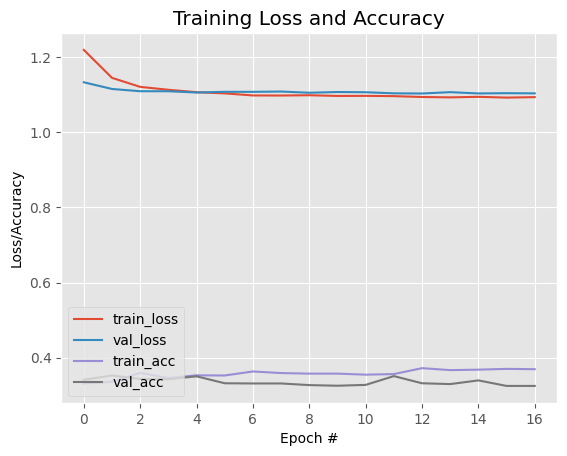

In [20]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)


# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)


# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs
	))

# # serialize the model to disk
# print("[INFO] saving mask detector model...")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [23]:
model.save("zuhair_mask_detector.model", save_format="h5")

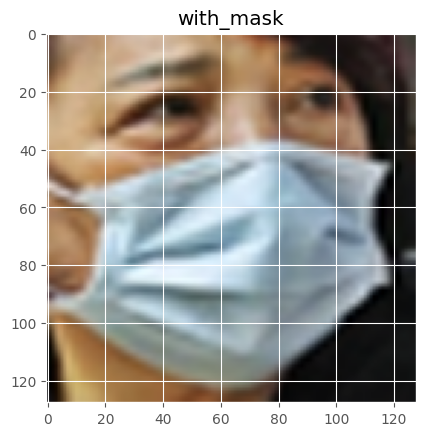

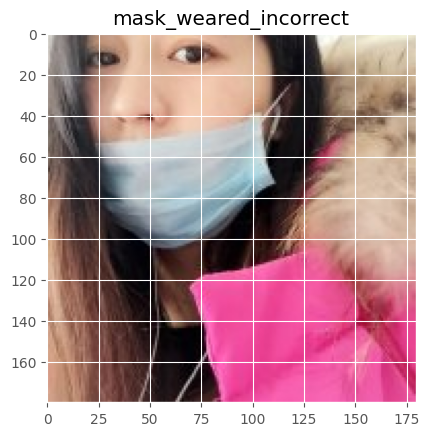

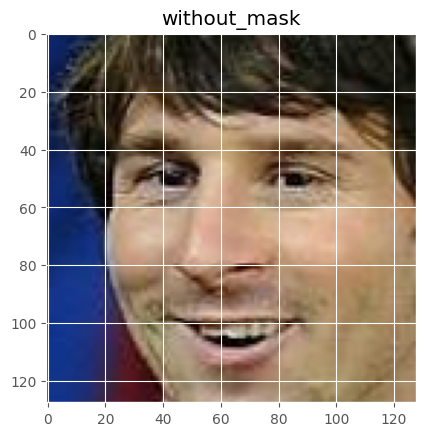

In [27]:
image01 = Image.open('Z:/Face-Mask/mask_dataset/with_mask/280.png')
image02 = Image.open('Z:/Face-Mask/mask_dataset/mask_weared_incorrect/2491.jpg')
image03 = Image.open('Z:/Face-Mask/mask_dataset/without_mask/81.png')

plt.figure('image01')
plt.title("with_mask")
plt.imshow(image01)

plt.figure('image02')
plt.title("mask_weared_incorrect")
plt.imshow(image02)

plt.figure('image03')
plt.title("without_mask")
plt.imshow(image03)

In [30]:
# Fixed the path of the haarcascade_frontalface_alt2.xml file
cascPath = os.path.join(cv2.data.haarcascades, "haarcascade_frontalface_alt2.xml")
faceCascade = cv2.CascadeClassifier(cascPath)

# Fixed the path of the mask_recog.h5 file
model = load_model("zuhair_mask_detector.model")

cap = cv2.VideoCapture(0)
while True:
    
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.flip(frame, 1)  # Flip the frame horizontally
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray,
                                         scaleFactor=1.1,
                                         minNeighbors=5,
                                         minSize=(60, 60),
                                         flags=cv2.CASCADE_SCALE_IMAGE)
    faces_list = []
    for (x, y, w, h) in faces:
        face_frame = frame[y:y+h, x:x+w]
        face_frame = cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB)
        face_frame = cv2.resize(face_frame, (224, 224))
        face_frame = img_to_array(face_frame)
        face_frame = np.expand_dims(face_frame, axis=0)
        face_frame = preprocess_input(face_frame)
        faces_list.append(face_frame)

    # Moved the prediction outside of the for loop so that it is only called once per frame
    if len(faces_list) > 0:
        preds = model.predict(faces_list)
    else:
        preds = []

    for (x, y, w, h), pred in zip(faces, preds):
        (mask_weared_incorrect, with_mask, without_mask) = pred
        
        if (with_mask > without_mask and with_mask > mask_weared_incorrect):
            label = "Mask Worn Properly :)"
            color = (0, 255, 0) 
        elif (without_mask > with_mask and without_mask > mask_weared_incorrect):
            label = "No Mask! (please wear)"
            color = (0, 0, 255)    
        else:
            label = "Wear Mask Properly!"
            color = (255, 140, 0)
        # include the probability in the label
        label = "{}: {:.2f}%".format(label,
                                     max(with_mask, mask_weared_incorrect, without_mask) * 100)
        cv2.putText(frame, label, (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)

    # Show the image
    cv2.imshow('LIVE', frame)
    key = cv2.waitKey(10)
    # if Esc key is press then break out of the loop 
    if key == 27: #The Esc key
        break


# Release the video capture object and destroy the windows

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 50ms/step


In [34]:
#Any Image Prediction
image01 = cv2.resize(cv2.imread('Z:/Face-Mask/mask_dataset/with_mask/110.png'), (resize, resize))
image01 = image01.astype("float") / 255.0
image01 = image01.reshape((1, image01.shape[0], image01.shape[1], image01.shape[2]))

image02 = cv2.resize(cv2.imread('Z:/Face-Mask/mask_dataset/mask_weared_incorrect/2491.jpg'), (resize, resize))
image02 = image02.astype("float") / 255.0
image02 = image02.reshape((1, image02.shape[0], image02.shape[1], image02.shape[2]))

image03 = cv2.resize(cv2.imread('Z:/Face-Mask/mask_dataset/without_mask/81.png'), (resize, resize))
image03 = image03.astype("float") / 255.0
image03 = image03.reshape((1, image03.shape[0], image03.shape[1], image03.shape[2]))


    
labelz = ('mask_weared_incorrect', 'with_mask', 'without_mask')

predict = model.predict(image01, verbose=1)
i = predict.argmax(axis=1)[0]
print(labelz[i])

predict = model.predict(image02, verbose=1)
i = predict.argmax(axis=1)[0]
print(labelz[i])

predict = model.predict(image03, verbose=1)
i = predict.argmax(axis=1)[0]
print(labelz[i])

1/1 [==============================] - 0s 57ms/step
with_mask
1/1 [==============================] - 0s 60ms/step
mask_weared_incorrect
1/1 [==============================] - 0s 56ms/step
without_mask
